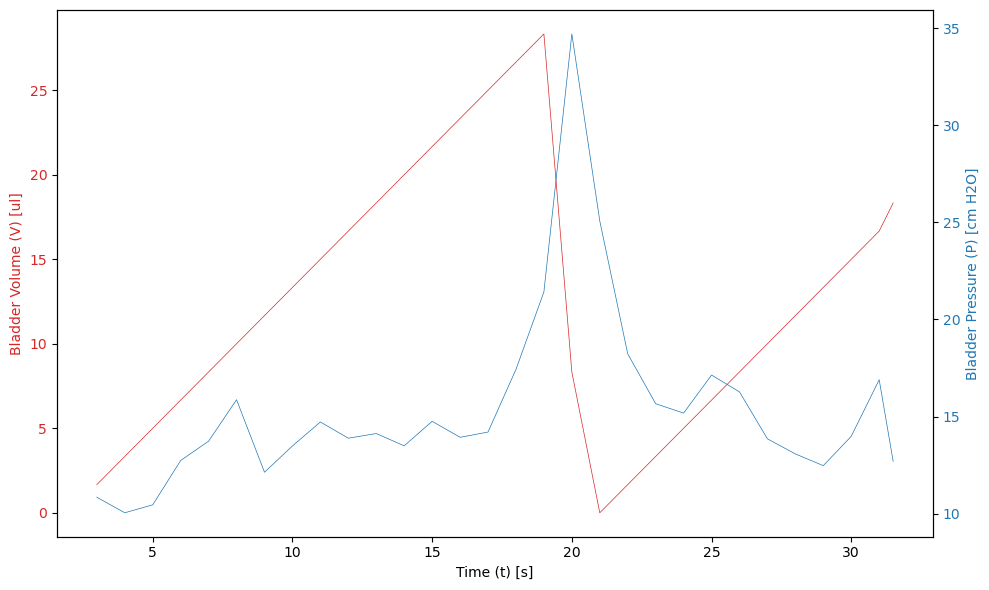

In [5]:
import pandas as pd
from utiles import volume_pressure_plot

bladder_volume = pd.read_csv('../output/bladder_volume.csv').to_numpy()
bladder_pressure = pd.read_csv('../output/bladder_pressure.csv').to_numpy()
feedback_times = pd.read_csv('../output/feedback_times.csv').to_numpy()

volume_pressure_plot(bladder_volume,bladder_pressure,feedback_times,save_fig=False,show_fig=True)

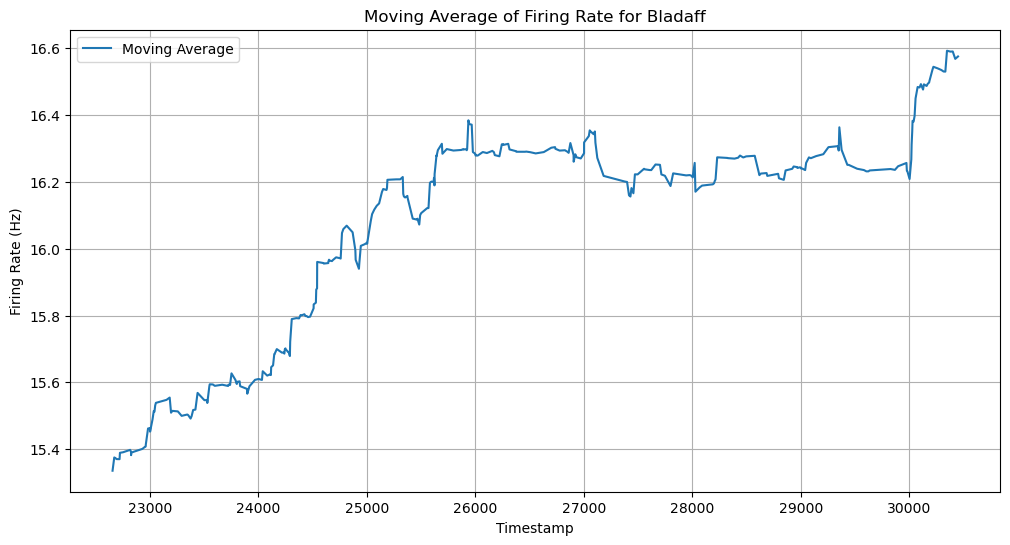

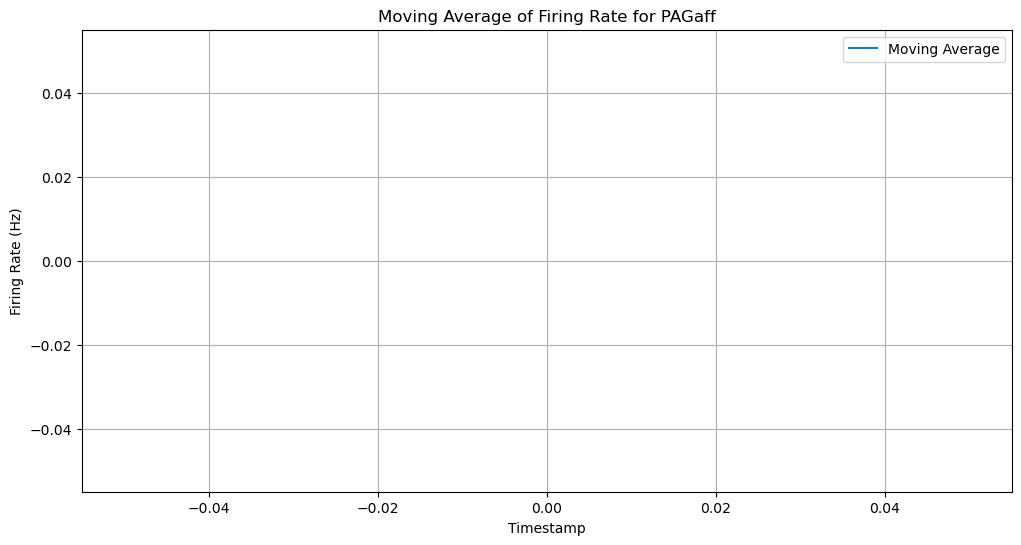

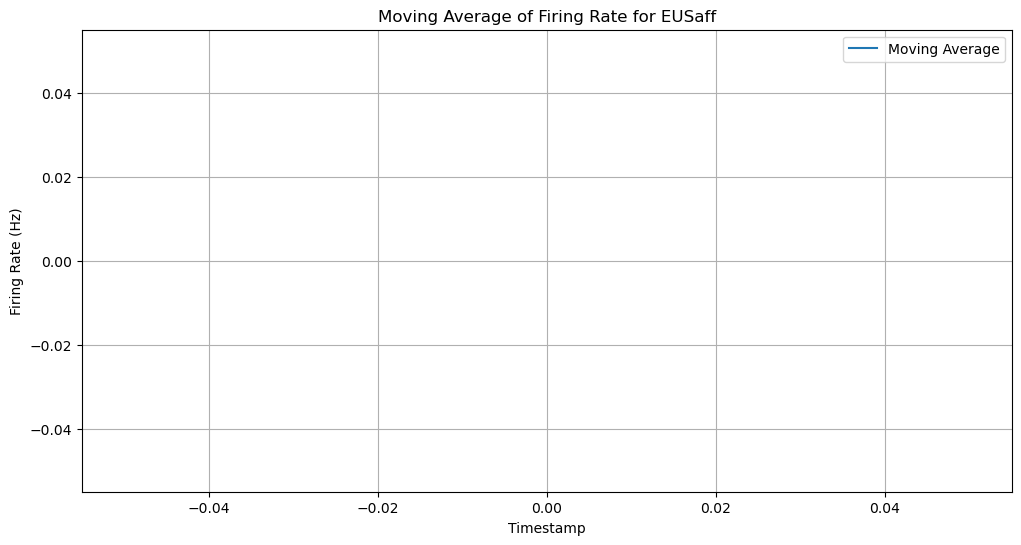

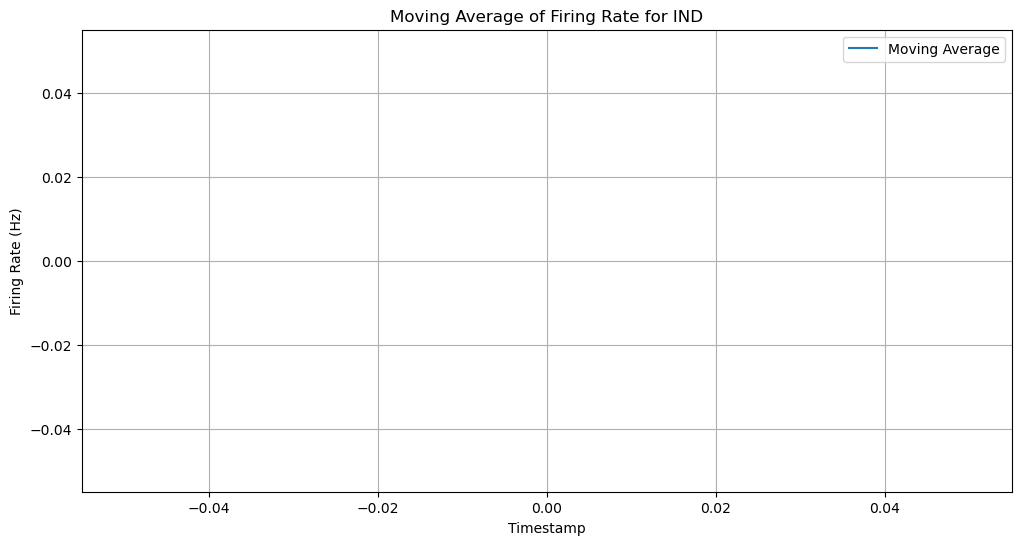

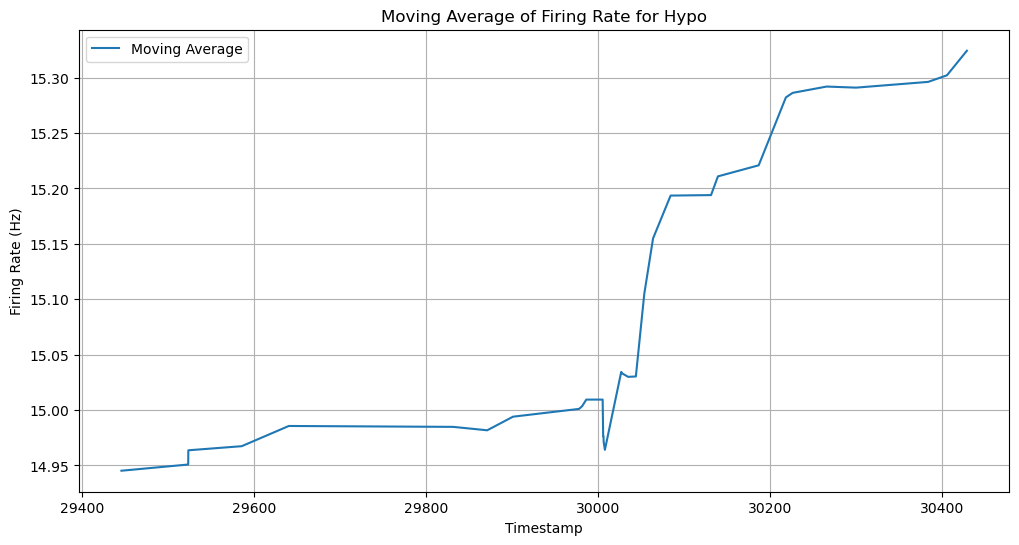

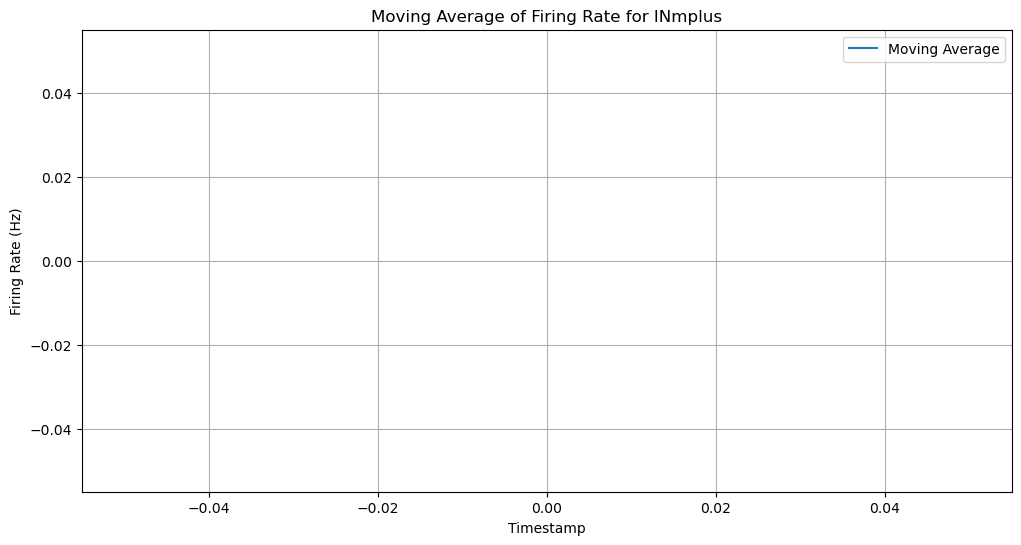

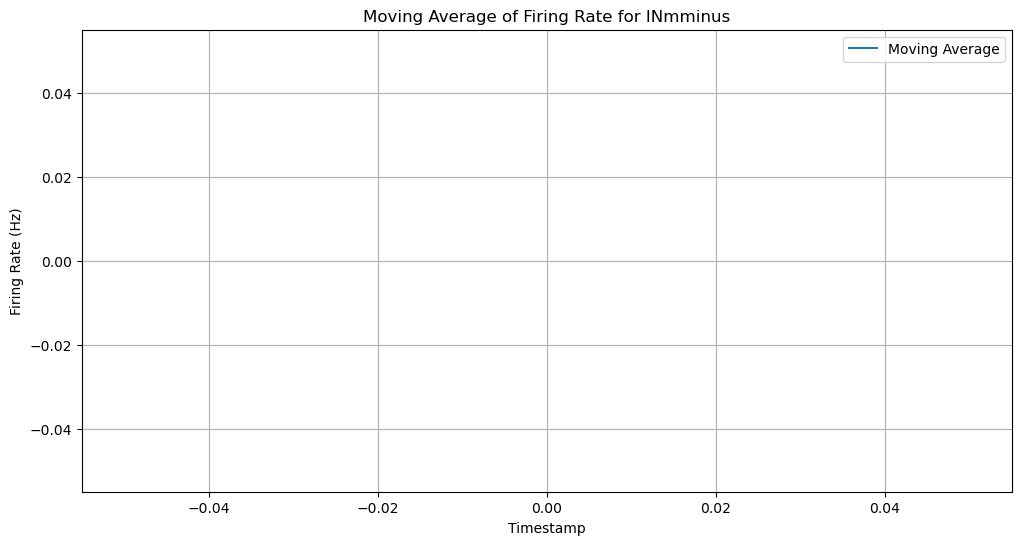

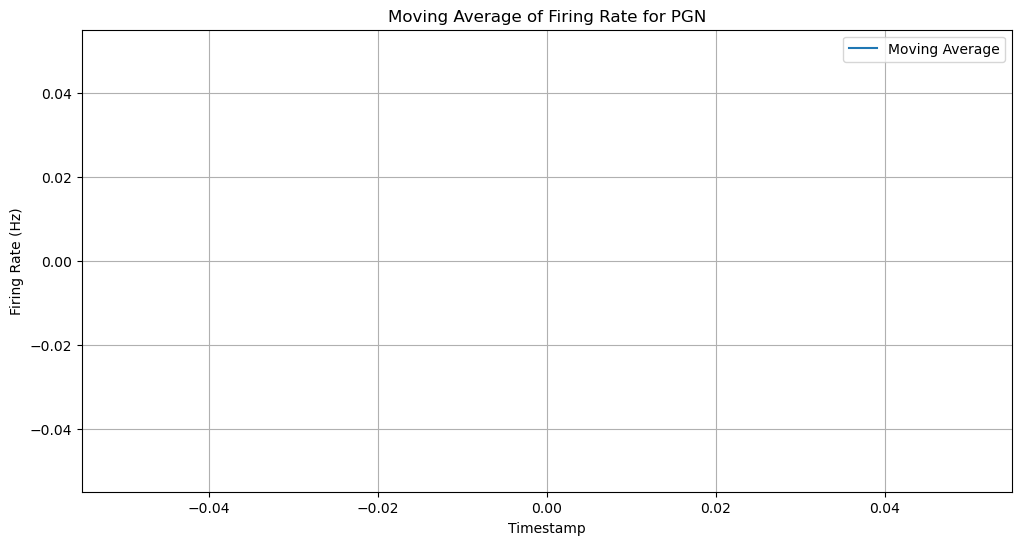

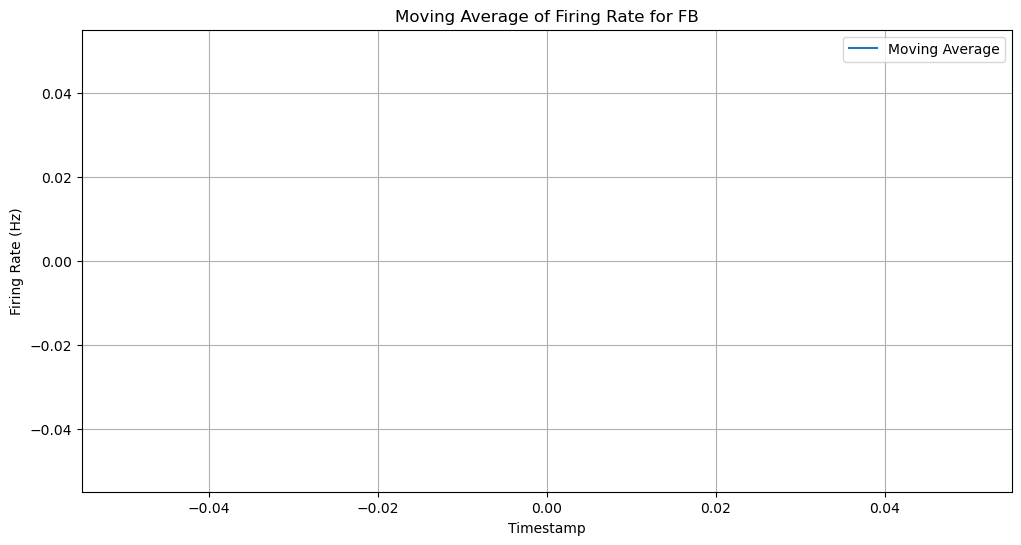

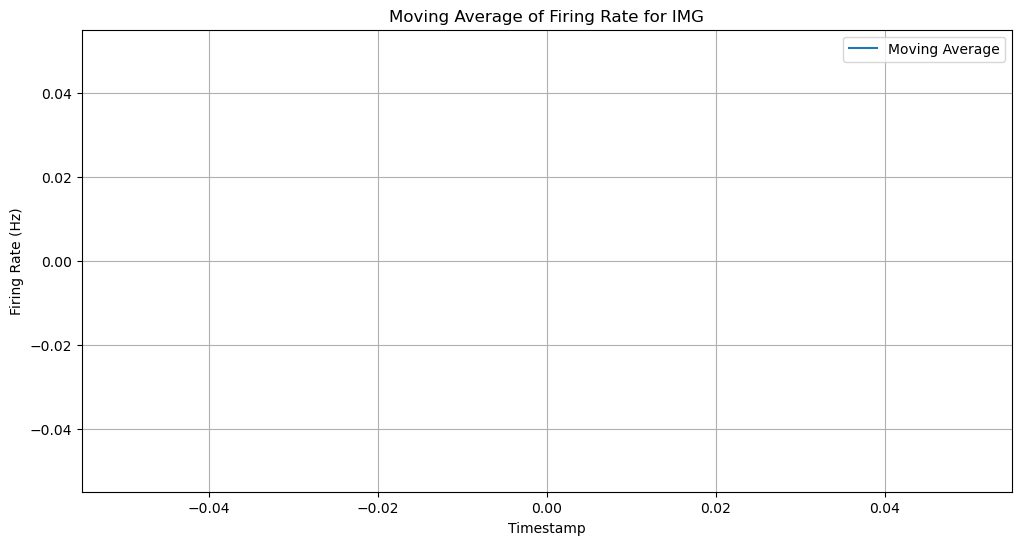

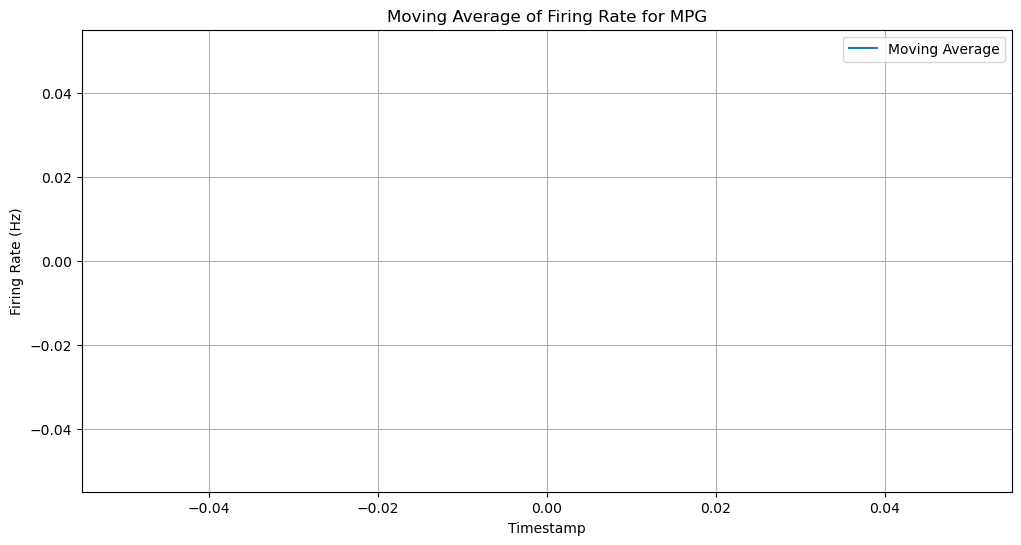

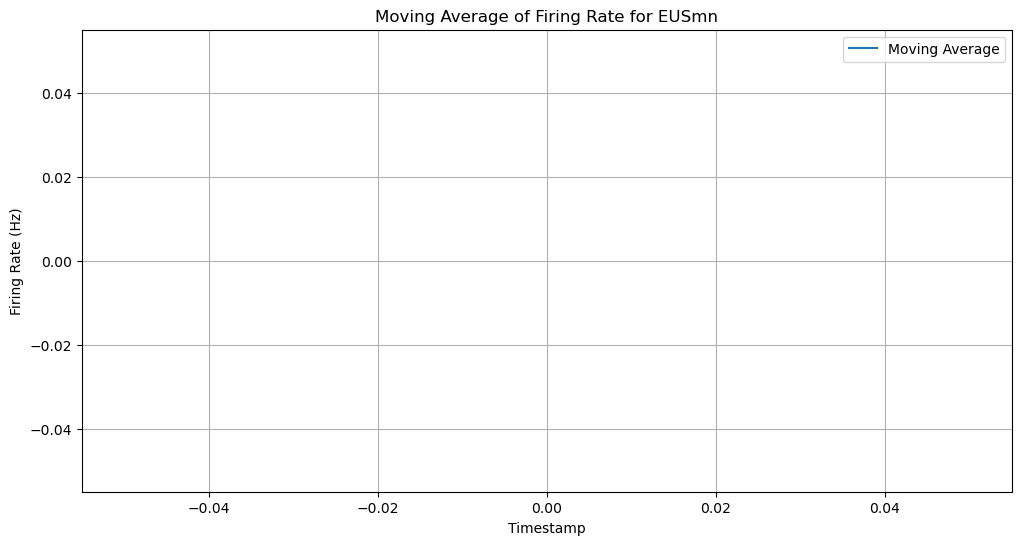

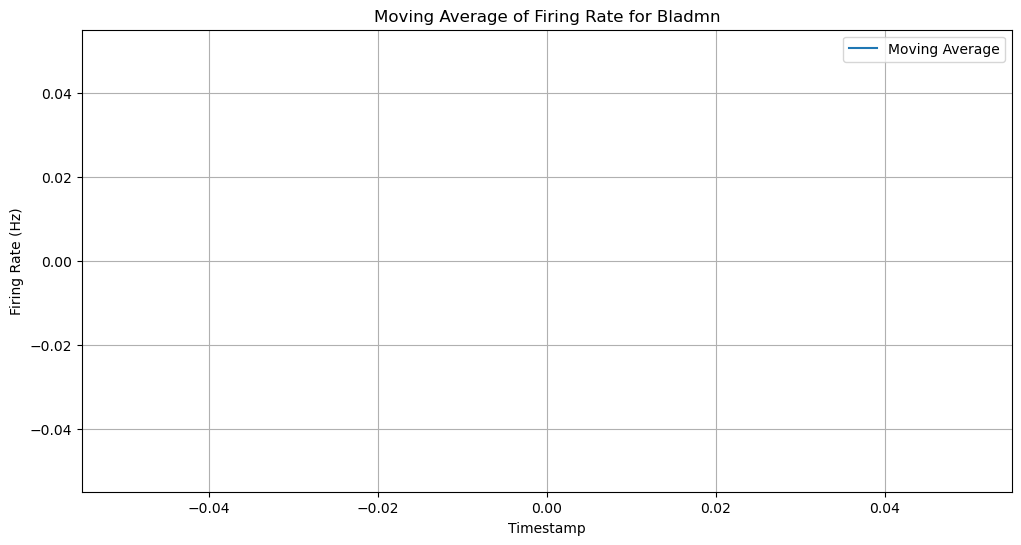

In [6]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
import sys
sys.path.append('..')

from model_parameters import model_settings
model = model_settings()
node_set = model.node_set

# Function to calculate the moving average of the firing rate for a group
def calculate_group_moving_avg(df, node_set, window_size):
    results = {}
    for group in node_set:
        # Filter nodes belonging to the group
        mask = (df['node_ids'] >= group['start']) & (df['node_ids'] <= group['end'])
        group_df = df.loc[mask].copy()  # Make a copy to avoid modifying the original DataFrame
        
        # Calculate inter-spike intervals (ISIs) in seconds
        group_df['isi'] = group_df.groupby('node_ids')['timestamps'].diff().fillna(0) / 1000
        
        # Convert ISIs to firing rates (Hz), handling division by zero
        group_df['firing_rate'] = group_df['isi'].apply(lambda x: 1 / x if x > 0 else 0)
        
        # Aggregate firing rates across the group by summing them up at each timestamp
        aggregated_df = group_df.groupby('timestamps')['firing_rate'].sum().reset_index()
        
        # Calculate moving average of the aggregated firing rate
        aggregated_df['moving_avg'] = aggregated_df['firing_rate'].rolling(window=window_size).mean()
        
        results[group['name']] = aggregated_df[['timestamps', 'moving_avg']]
    return results


# Usage
window_size = 1000  # Define your window size for the moving average
f = h5py.File('../output/spikes.h5')
df = pd.DataFrame({
    'node_ids': f['spikes']['LUT']['node_ids'], 
    'timestamps': f['spikes']['LUT']['timestamps']
})

group_moving_avgs = calculate_group_moving_avg(df, node_set, window_size)

# Function to plot the moving average
def plot_group_moving_avgs(group_moving_avgs):
    for group_name, stats in group_moving_avgs.items():
        plt.figure(figsize=(12, 6))
        plt.plot(stats['timestamps'], stats['moving_avg'], label='Moving Average')
        plt.title(f'Moving Average of Firing Rate for {group_name}')
        plt.xlabel('Timestamp')
        plt.ylabel('Firing Rate (Hz)')
        plt.legend()
        plt.grid(True)
        plt.show()

plot_group_moving_avgs(group_moving_avgs)


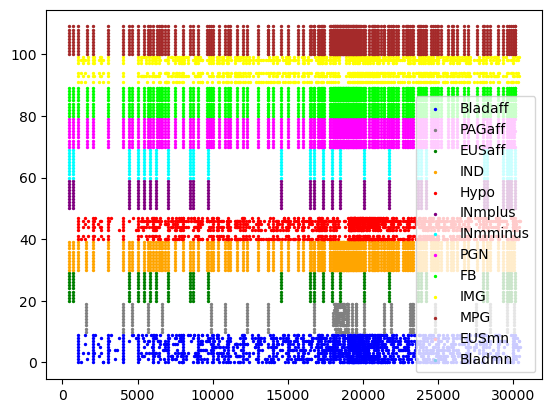

In [7]:
def raster(spikes_df, node_set, start=0,end=80000):
    spikes_df = spikes_df[spikes_df['timestamps'] > start]
    spikes_df = spikes_df[spikes_df['timestamps'] < end]
    for node in node_set:
        cells = range(node['start'], node['end'] + 1)  # +1 to be inclusive of last cell
        cell_spikes = spikes_df[spikes_df['node_ids'].isin(cells)]

        plt.scatter(cell_spikes['timestamps'], cell_spikes['node_ids'],
                   c=node['color'], s=2, label=node['name'])

    plt.gca().legend(loc='lower right')
    plt.grid(False)


raster(df,node_set)